# TBSS Tutorial

TBSS stands for **Tract-Based Spatial Statistics**, a suite of tools for analyzing diffusion data. TBSS comes installed as part of the FSL software package. TBSS uses a tensor-fitting method to generate different measures of diffusion, such as fractional anisotropy (FA) and mean diffusivity (MD). Once these measurements are created, you can then extract them using ROI tools like you would for fMRI data.

The package also includes tools for correctying distortions in the diffusion data; in particular, the commands topup and eddy will remove distortions caused by eddy currents and magnetic field inhomogeneities.


**Authors:** Andrew Jahn & Monika Doerig

**Date:** 20 June 2025

### Citation and Resources:

#### Tools included in this workflow

__TBSS:__ 
- S.M. Smith, M. Jenkinson, H. Johansen-Berg, D. Rueckert, T.E. Nichols, C.E. Mackay, K.E. Watkins, O. Ciccarelli, M.Z. Cader, P.M. Matthews, and T.E.J. Behrens. Tract-based spatial statistics: Voxelwise analysis of multi-subject diffusion data. NeuroImage, 31:1487-1505, 2006.
- For more details: [https://ftp.nmr.mgh.harvard.edu/pub/dist/freesurfer/tutorial_packages_centos6/centos6/fsl_507/doc/wiki/TBSS.html](https://ftp.nmr.mgh.harvard.edu/pub/dist/freesurfer/tutorial_packages_centos6/centos6/fsl_507/doc/wiki/TBSS.html)

__MRtrix3:__
- Tournier, J.-D., Smith, R., Raffelt, D., Tabbara, R., Dhollander, T., Pietsch, M., Christiaens, D., Jeurissen, B., Yeh, C.-H., & Connelly, A. (2019). MRtrix3: A fast, flexible and open software framework for medical image processing and visualisation. NeuroImage, 202, 116137. [https://doi.org/10.1016/j.neuroimage.2019.116137](https://doi.org/10.1016/j.neuroimage.2019.116137)


#### Educational resources

__Andy's Brain Book:__

- This notebook is based on the [TBSS Analysis Tutorial](https://andysbrainbook.readthedocs.io/en/latest/TBSS/TBSS_Overview.html#) chapter from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

#### Dataset
__Opensource Data from OpenNeuro:__
- Hannelore Aerts and Daniele Marinazzo (2018). BTC_preop. [OpenNeuro Dataset ds001226](https://openneuro.org/datasets/ds001226/versions/00001)


<div style="background-color: #ABBAEF; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
        Before beginning, you may want to review the basics of diffusion imaging, which can be found <a href="https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_00_Diffusion_Overview.html#mrtrix-00-diffusion-overview" style="color: #007bff; text-decoration: none;">here</a>. The chapter will review the principles of diffusion, how they are used to generate diffusion-weighted images, and the advantages and disadvantages of fitting tensors to diffusion data.
    </p>
</div>

## Goals of This Tutorial

This tutorial will show you how to analyze a sample dataset from start to finish using TBSS. We will be closely following the steps provided on the FSL TBSS website; the goal is to provide you with more experience in how to use this package, and use figures and videos to broaden your understanding of how it works and how it can be applied in other scenarios.

## Import Python Packages

In [1]:
%%capture
! pip install nibabel nilearn numpy

In [2]:
import os
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import nilearn
from nilearn import plotting, image
from IPython.display import display, clear_output, Image
import time
from ipyniivue import NiiVue 

## Load Neuroimaging Software (MRtrix and TBSS)

In [3]:
import module
await module.load('mrtrix3/3.0.4')
await module.load('fsl/6.0.3') # Need to use this version in order for TBSS commands to work
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.3']

Try typing one of the commands from the library, such as ```fslinfo```. If FSL has been installed correctly, you should see the help page printed by default when no arguments are passed to the command:

In [4]:
!fslinfo

Usage: /opt/fsl-6.0.3/bin/fslinfo <filename>


If this works without any errors, you are ready to begin analyzing the dataset.

## Downloading the Dataset

For this example, we will be preprocessing a dataset from openneuro.org called [BTC preop](https://openneuro.org/datasets/ds001226/versions/00001). It includes data from patients with gliomas, patients with meningiomas, and a group of control subjects.

To download the data of one subject, excute the next cell:

In [5]:
PATTERN = "sub-CON02"
!datalad install https://github.com/OpenNeuroDatasets/ds001226.git

!cd ds001226 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/25.9k [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/18.7k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/25.9k [00:00<?, ? Objects/s]
Receiving:  66%|█████████████▊       | 17.1k/25.9k [00:00<00:00, 171k Objects/s]
                                                                                
Resolving:   0%|                              | 0.00/4.30k [00:00<?, ? Deltas/s]
[INFO   ] scanning for unlocked files (this may take some time)                 
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore 
[INFO   ] access to 1 dat

####
If you want to download more subjects, here is an example how to get 4 controls and 4 patients:
```
PATTERN_CONTROLS="sub-CON0[1-4]"
PATTERN_PATIENTS="sub-PAT0[1-4]"

! datalad install https://github.com/OpenNeuroDatasets/ds001226.git

! cd ds001226 && datalad get $PATTERN_CONTROLS $PATTERN_PATIENTS
```


## Looking at the Data
In order to view the data, we will navigate to the folder sub-CON02/ses-preop/dwi, which contains the diffusion data. We import the ```os``` package to change directories, and also to list the contents of that directory:

In [6]:
# Navigate to the diffusion data
os.chdir("ds001226/sub-CON02/ses-preop/dwi")

In [7]:
os.listdir()

['sub-CON02_ses-preop_acq-PA_dwi.bvec',
 'sub-CON02_ses-preop_acq-PA_dwi.bval',
 'sub-CON02_ses-preop_acq-AP_dwi.bval',
 'sub-CON02_ses-preop_acq-PA_dwi.json',
 'sub-CON02_ses-preop_acq-AP_dwi.json',
 'sub-CON02_ses-preop_acq-PA_dwi.nii.gz',
 'sub-CON02_ses-preop_acq-AP_dwi.bvec',
 'sub-CON02_ses-preop_acq-AP_dwi.nii.gz']

<div style="background-color: #ABBAEF; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
To make the rest of the example easier to read as well, use the <code>mv</code> command to rename the .bval and .bvec files:
    </p>
</div>

In [8]:
! mv sub-CON02_ses-preop_acq-AP_dwi.bvec sub-02_AP.bvec
! mv sub-CON02_ses-preop_acq-AP_dwi.bval sub-02_AP.bval
! mv sub-CON02_ses-preop_acq-PA_dwi.bvec sub-02_PA.bvec
! mv sub-CON02_ses-preop_acq-PA_dwi.bval sub-02_PA.bval

In [9]:
! fslinfo sub-CON02_ses-preop_acq-AP_dwi.nii.gz

data_type	INT16
dim1		96
dim2		96
dim3		60
dim4		102
datatype	4
pixdim1		2.500000
pixdim2		2.500000
pixdim3		2.500000
pixdim4		8.700000
cal_max		0.000000
cal_min		0.000000
file_type	NIFTI-1+


Note that, since this is a 4-dimensional dataset, the last dimension is time; in other words, this file contains 102 volumes, each one with dimensions of 96 x 96 x 60 voxels. The last dimension of the *Voxel size* field - which in this case has a value of 8.7 - indicates the time it took to acquire each volume, the repetition time, or TR.

#### __Bvals and Bvecs__
The other files we need to check are the ```bvals``` and ```bvecs files```. Briefly, the bvals contain a single number per volume that indicates how large of a diffusion gradient was applied to the data; and the bvecs file contains a triplet of numbers per volume that shows in what directions the gradients were applied. In general, volumes with larger b-values will be more sensitive to diffusion changes, but the images will also be more susceptible to motion and physiological artifacts.

The most important check is to ensure that the number of bvals and the number of bvecs are the same as the number of volumes in the dataset. For example, we can find the number of volumes in the sub-CON02_ses-preop_acq-AP_dwi.nii.gz dataset by typing:

In [10]:
! fslinfo sub-CON02_ses-preop_acq-AP_dwi.nii.gz | awk 'FNR == 5 {print $2}'

102


Which returns a value of 102, the number in the 4th field of the dimensions header that corresponds to the number of time-points, or volumes, in the dataset. We then compare this with the number of bvals and bvecs by using awk to count the number of columns in each text file:

In [11]:
! awk '{print NF; exit}' sub-02_AP.bvec
! awk '{print NF; exit}' sub-02_AP.bval

102
102


<div style="background-color: #ABBAEF; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
If the number of volumes in your dataset and the number of bvals and bvecs do not match, you should check with your scan technician about the discrepancy; the files may not have been properly uploaded to the server, or maybe the diffusion-weighted image wasn’t acquired correctly.
    </p>
</div>

#### __Visualization__
In order to view the image, we will use a couple of different packages, and you can determine which one you prefer. The first one we will use it ```matplotlib```, which was loaded earlier in this notebook. In the code below, we will temporarily convert the data to NIFTI format and plot 3 volumes with Matplotlib. 

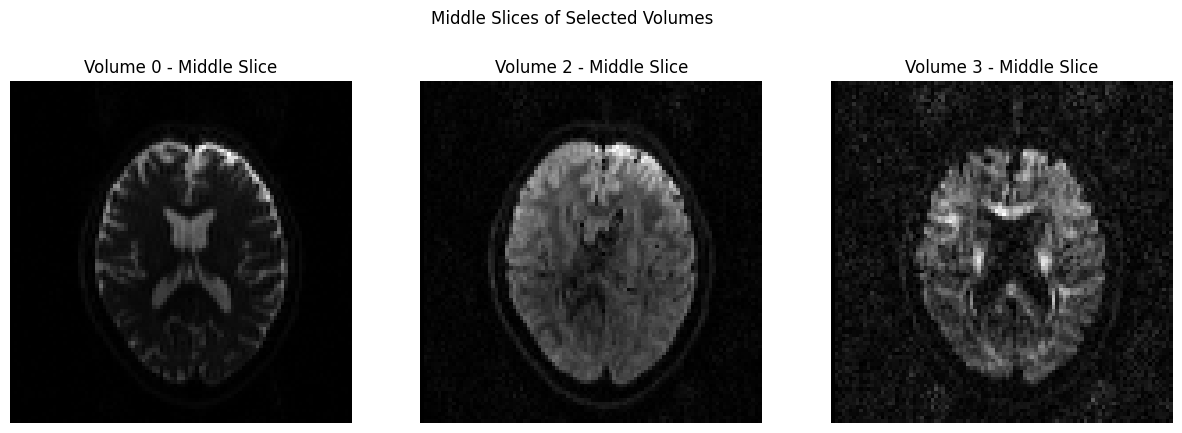

In [12]:
dwi_file = 'sub-CON02_ses-preop_acq-AP_dwi.nii.gz'  

# Load the NIfTI file
nii_image = nib.load(dwi_file)
data = nii_image.get_fdata()

# Define volume indices for the three volumes you want to display
volume_indices = [0, 2, 3]  
slice_index = data.shape[2] // 2  # Choose the middle slice for visualization

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, vol_idx in enumerate(volume_indices):
    # Extract the middle slice from the selected volume and rotate it 90°
    rotated_slice = np.rot90(data[:, :, slice_index, vol_idx]) 
    axes[i].imshow(rotated_slice, cmap="gray")
    axes[i].set_title(f"Volume {vol_idx} - Middle Slice")
    axes[i].axis("off")

plt.suptitle("Middle Slices of Selected Volumes")
plt.show()

Another way to view these images is through nilearn, which contains a plotting library. The code below will import the necessary packages, and then extract and plot the first volume of the time-series. This opens an interactive plot upon which you can click and drag your mouse cursor. Note in particular that the frontal pole is slightly deformed and squished inwards; we will fix that by using ```topup```.

(96, 96, 60, 102)


/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:805: UserWarning: Casting data from int32 to float32
  return resample_img(



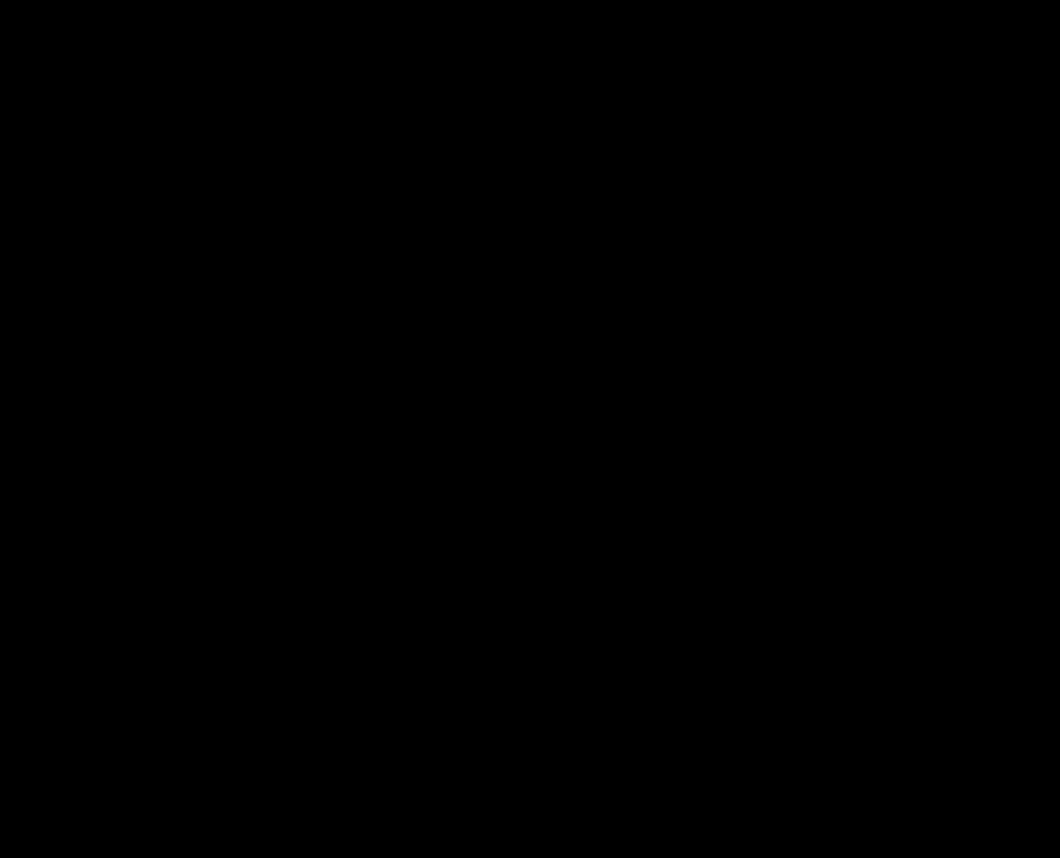
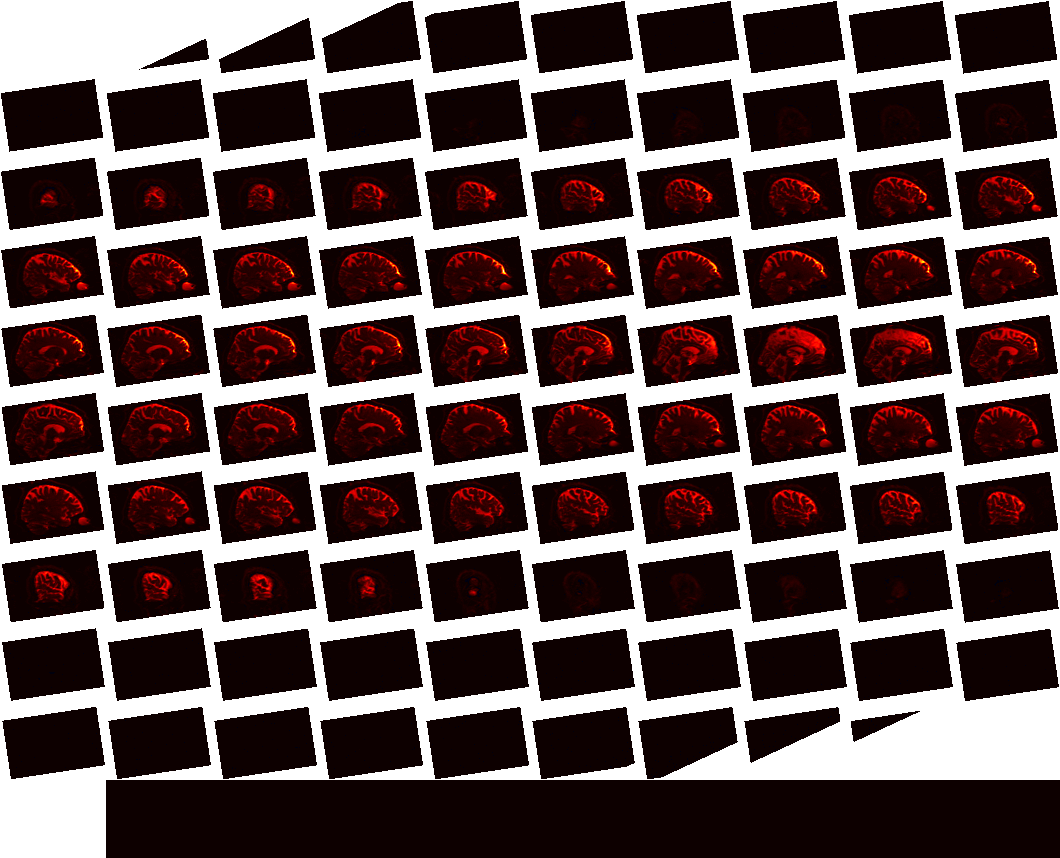

In [13]:
dwi_image = 'sub-CON02_ses-preop_acq-AP_dwi.nii.gz'
print(image.load_img(dwi_image).shape)
first_dwi_volume = image.index_img(dwi_image,0) # Load first volume of DWI time-series
plotting.view_img(first_dwi_volume, bg_img=False, threshold=None)

## topup
The first preprocessing step we will do is topup, which is designed to correct distortions caused by magnetic field inhomogeneities. These inhomogeneities are particularly noticeable near the sinuses and around the edges of the brain, especially along the axis of the phase-encoding direction. For example, if we collect our images using an anterior-to-posterior phase-encoding direction, the inhomogeneities will be most noticeable at the front and back of the head, as you can see in the image above.

These inhomogeneities are easiest to detect in the images that do not have any diffusion-weighting applied; in other words, the images with a b-value of 0. In this dataset, we have seen that the first volume of the AP and PA datasets both have a b-value of 0. Consequently, we will extract these volumes using the command fslroi:

In [14]:
!fslroi sub-CON02_ses-preop_acq-AP_dwi.nii.gz AP 0 1
!fslroi sub-CON02_ses-preop_acq-PA_dwi.nii.gz PA 0 1

This creates two new files, “AP.nii.gz” and “PA.nii.gz”. We then combine them using fslmerge:

In [15]:
!fslmerge -t AP_PA AP.nii.gz PA.nii.gz

to create the file “AP_PA.nii.gz”. Try opening this file in fsleyes and toggling back and forth between the two volumes to see how they have been combined into a single dataset.

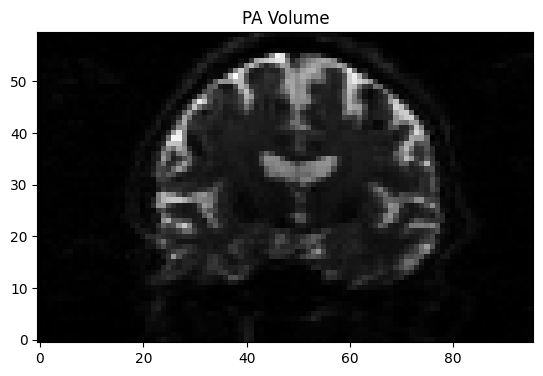

In [16]:
img = nib.load("AP_PA.nii.gz")
data = img.get_fdata()
mid_slice = data.shape[1] // 2  # middle sagittal slice

for i in range(10):  # flip 10 times between AP and PA volume
    for vol in range(2):
        plt.imshow(data[:, mid_slice, :, vol].T, cmap='gray', origin='lower')
        plt.title(f"{'AP' if vol == 0 else 'PA'} Volume")
        display(plt.gcf())
        time.sleep(1.0) # flip every second
        clear_output(wait=True)

We will also need to create a file that indicates the phase-encoding direction and the read-out time. Using a text editor of your choice, or simply using Python code, you can write the following numbers into a file called ```acq_param.txt```:

In [17]:
text_to_save = "0 1 0 0.0266003 \n0 -1 0 0.0266003"
file_path = "acq_param.txt"

with open(file_path, 'w') as file:
    file.write(text_to_save)

To check whether the numbers were saved correctly, type:

In [18]:
with open('acq_param.txt', 'r') as f:
    print(f.read())

0 1 0 0.0266003 
0 -1 0 0.0266003


The first three numbers in the first row represent the phase-encoding along the x-, y-, and z-dimensions. Since the first volume was acquired in the A-P direction, we place a “1” in the second column. In the next row, since the second image in this dataset was acquired in the opposite direction, we use a value of “-1”. The last column is the read-out time, in milliseconds; if it’s the same for both images, you can set it to “1”. Otherwise, replace it with the exact read-out time for each volume separately. For the current dataset, this number can be found in the “TotalReadOutTime” field of the “.json” file in the dwi directory.

Once you have all of these ingredients, you are ready to run topup to estimate the field inhomogeneity:

In [19]:
!topup --imain=AP_PA.nii.gz --datain=acq_param.txt --config=b02b0.cnf --out=AP_PA_topup

The option --config=b02b0.cnf may look out of place, since we didn’t create a file with that name; do not worry, however, since this is a default file that is included in FSL’s libraries and will be automatically detected if you include it. The configuration parameters specified in the file are designed to work with most diffusion imaging data, so don’t change it unless you have a custom configuration file you created yourself.

After a few minutes, you will see a few new files, including one called AP_PA_topup_fieldcoef.nii.gz. These are the inhomogeneity estimations, which you can view in fsleyes if you like. We can now apply them to the original A-P phase-encoded data, which we will be using for our diffusion analysis:

In [20]:
!applytopup --imain=sub-CON02_ses-preop_acq-AP_dwi.nii.gz --inindex=1 --datain=acq_param.txt --topup=AP_PA_topup --method=jac --out=AP_Cor

This uses the fieldmap estimated above, as specified by the --topup option, to unwarp the A-P data. The inindex option, which we have set to 1, indicates that we are applying the unwarping to the phase-encoded image represented in the first line of the “acq_param.txt” file. --method=jac uses jacobin modulation, and --out is used to specify a label for the output image.

When it is finished, you can open the image “AP_Cor.nii.gz” in fsleyes (or, alternatively, you can use the Python code below). Load the raw “sub-CON02_ses-preop_acq-AP_dwi.nii.gz” image as well and toggle between the two using the eye icon in the GUI in order to see the image before and after unwarping. If you are satisfied with the results, we can move on to the next preprocessing step of fitting the tensors.

(96, 96, 60, 102)


/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:805: UserWarning: Casting data from int32 to float32
  return resample_img(
/opt/conda/lib/python3.11/site-packages/nilearn/plotting/html_stat_map.py:414: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  bg_data = safe_get_data(bg_img, ensure_finite=True).astype(float)



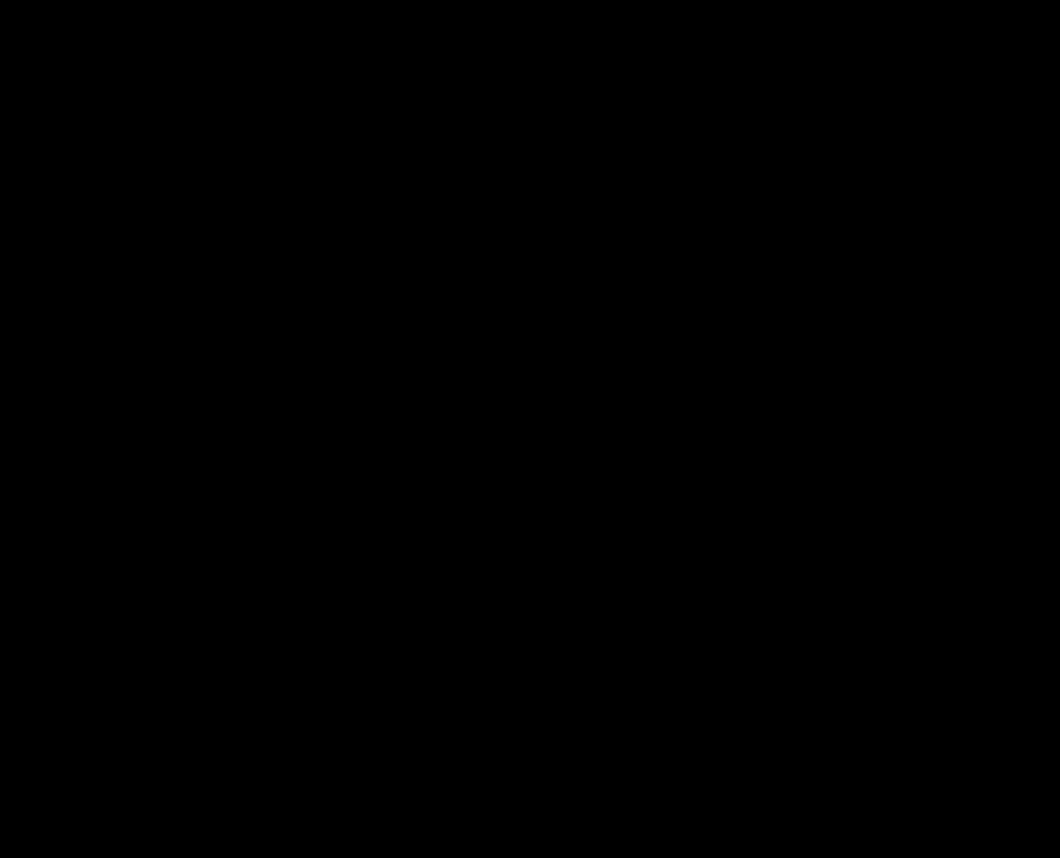
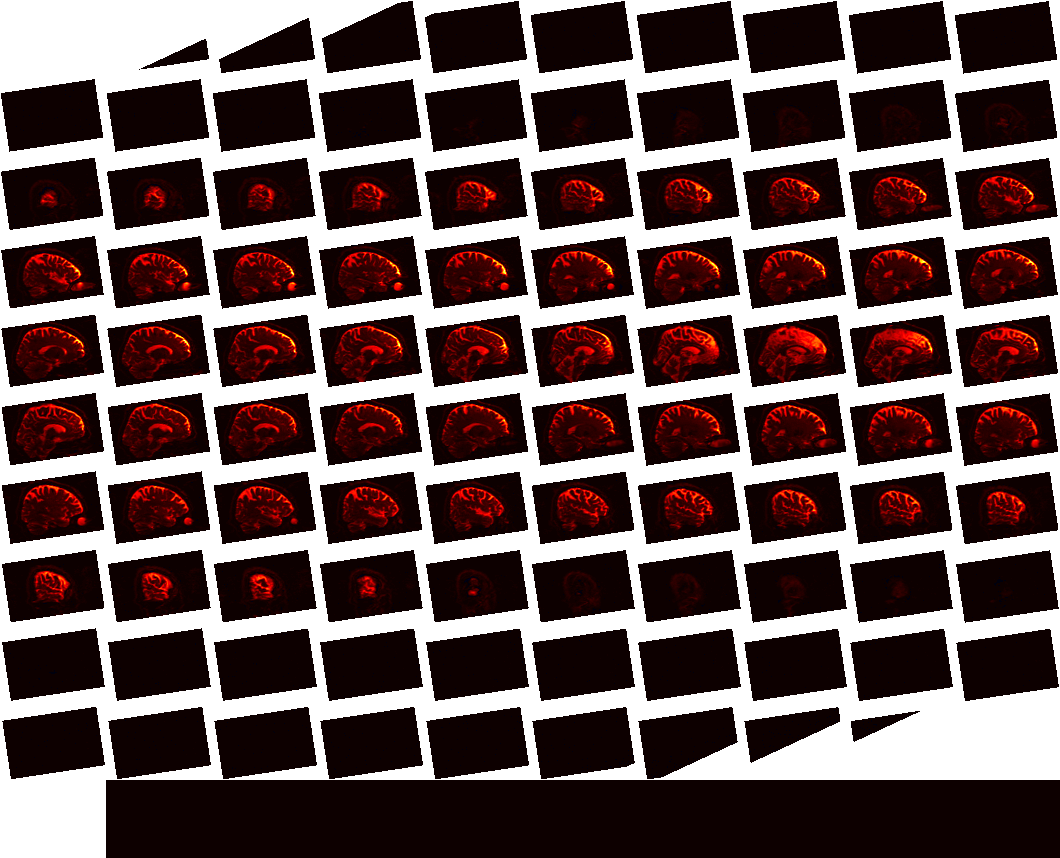

In [23]:
dwi_topup_image = 'AP_Cor.nii.gz'
print(image.load_img(dwi_topup_image).shape)
first_topup_volume = image.index_img(dwi_topup_image,0) # Load first volume of DWI time-series
plotting.view_img(first_topup_volume, bg_img=False, threshold=None)

Compare this to the previous unwarped image, for example, slice Z=30, to see how the distortions were corrected:

/opt/conda/lib/python3.11/site-packages/nilearn/image/resampling.py:805: UserWarning: Casting data from int32 to float32
  return resample_img(



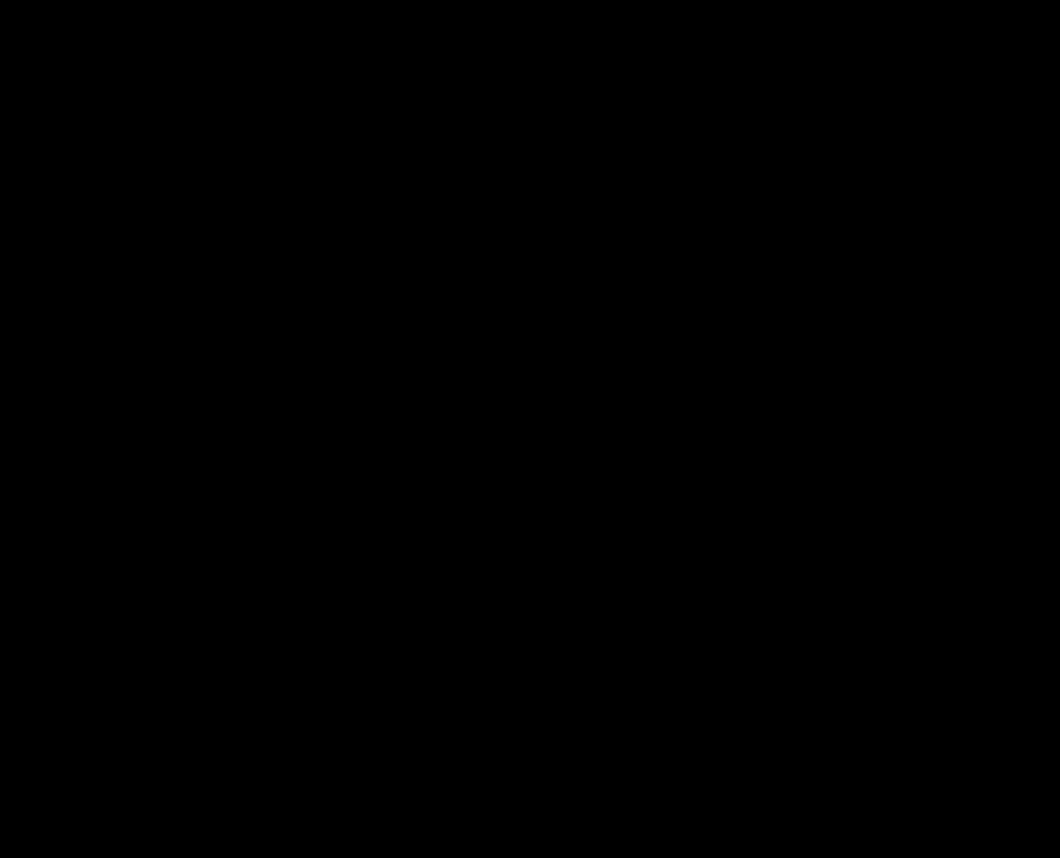
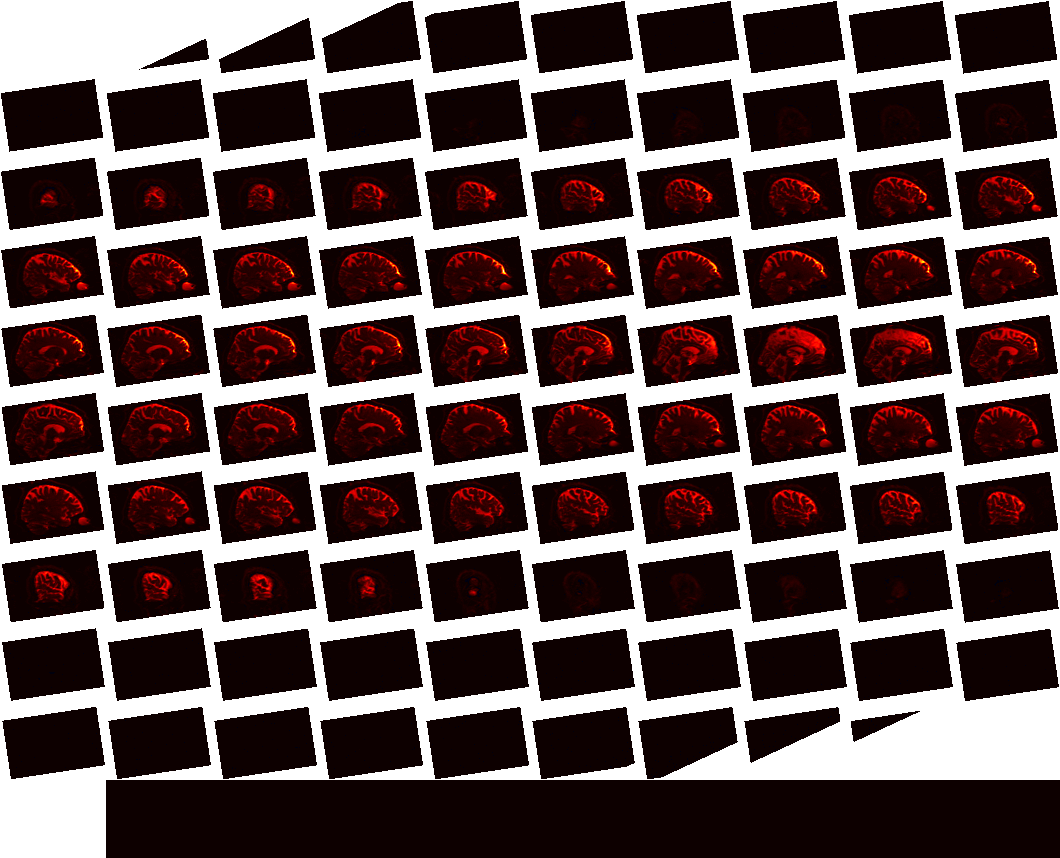

In [24]:
plotting.view_img(first_dwi_volume, bg_img=False, threshold=None)

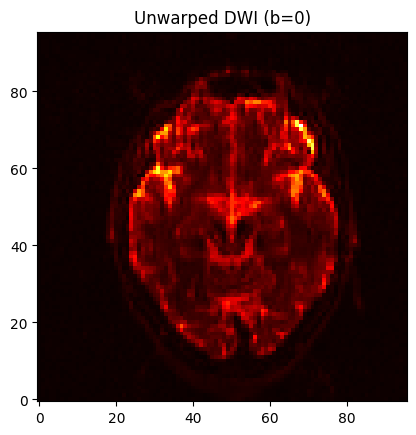

In [25]:
orig = nib.load('sub-CON02_ses-preop_acq-AP_dwi.nii.gz').get_fdata()[..., 0]
corr = nib.load('AP_Cor.nii.gz').get_fdata()[..., 0]

slice = 20 # or any other slice like mid slice = orig.shape[2] // 2  

for i in range(10):
    for vol, title, data in zip([0, 1], ["Warped", "Unwarped"], [orig, corr]):
        plt.imshow(data[:, :, slice].T, cmap='hot', origin='lower')
        plt.title(f"{title} DWI (b=0)")
        display(plt.gcf())
        time.sleep(1)
        clear_output(wait=True)

To run the following commands to fit the tensors, we will need to create a mask, which should be based on the corrected dataset that we generated using topup in the previous section. We will begin by extracting the first volume of that dataset using fslroi:

In [26]:
!fslroi AP_Cor.nii.gz AP_1stVol 0 1

And then use bet to create a mask from that image:

In [27]:
!bet AP_1stVol.nii.gz AP_brain -m -f 0.2


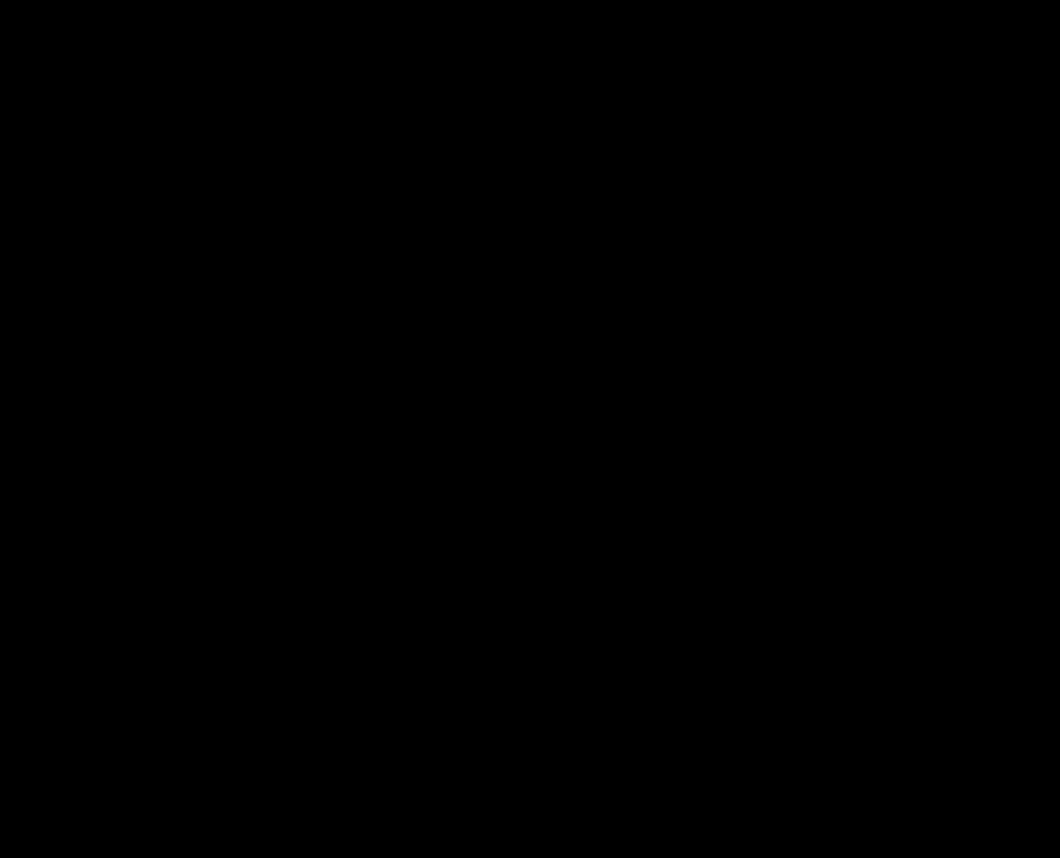
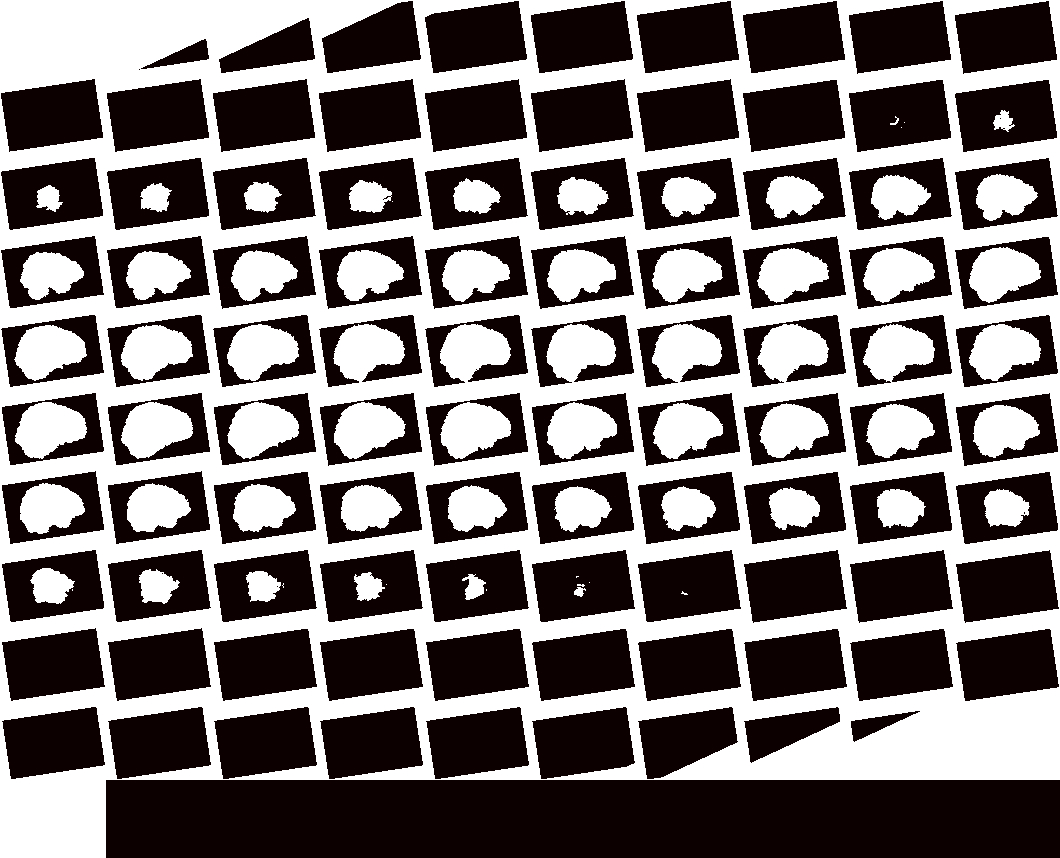

In [28]:
plotting.view_img('AP_brain_mask.nii.gz', bg_img=False, threshold=None, resampling_interpolation='nearest', colorbar=False)

In [29]:
nv = NiiVue()
nv.load_volumes([{"path": 'AP_brain_mask.nii.gz'}])
nv

NiiVue(clip_plane_depth_azi_elev=[2.0, 0.0, 0.0], draw_lut=None, graph=<ipyniivue.traits.Graph object at 0x7fe…

In [30]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/tbss_AP_brain_mask.png')

# Fitting the Tensors

Now that we have unwarped the data, we are ready to fit a tensor at each voxel, representing the direction and the magnitude of diffusion. For a review of what a tensor is and how it is modeled, see the section “Putting it all together: Modeling the tensor” in <a href="https://andysbrainbook.readthedocs.io/en/latest/MRtrix/MRtrix_Course/MRtrix_00_Diffusion_Overview.html#mrtrix-00-diffusion-overview" style="color: #007bff; text-decoration: none;">this chapter</a>.

The easiest way to fit the tensors is to use the Graphical User Interface by typing the command ```Fdt_gui```, selecting ```DTIFIT Reconstruct diffusion tensors``` from the dropdown menu, and filling in each of the fields. You can also run it from the command line by using the following code:


In [31]:
!dtifit --data=AP_Cor.nii.gz --out=dti --mask=AP_brain_mask.nii.gz --bvecs=sub-02_AP.bvec --bvals=sub-02_AP.bval

0 96 0 96 0 60
0 slices processed
1 slices processed
2 slices processed
3 slices processed
4 slices processed
5 slices processed
6 slices processed
7 slices processed
8 slices processed
9 slices processed
10 slices processed
11 slices processed
12 slices processed
13 slices processed
14 slices processed
15 slices processed
16 slices processed
17 slices processed
18 slices processed
19 slices processed
20 slices processed
21 slices processed
22 slices processed
23 slices processed
24 slices processed
25 slices processed
26 slices processed
27 slices processed
28 slices processed
29 slices processed
30 slices processed
31 slices processed
32 slices processed
33 slices processed
34 slices processed
35 slices processed
36 slices processed
37 slices processed
38 slices processed
39 slices processed
40 slices processed
41 slices processed
42 slices processed
43 slices processed
44 slices processed
45 slices processed
46 slices processed
47 slices processed
48 slices processed
49 slices proce

When it is done, load the files ```dti_V1``` and ```dti_FA``` in fsleyes. With the file ```dti_V1``` highlighted, click on the “Modulate by” menu and select ```dti_FA```. This will create an image that shows the primary direction of diffusion at each voxel, with red representing diffusion that is primarily left to right, green representing back to forward, and blue representing bottom to top. If the tensors were fit correctly, you should see mostly red in the corpus callosum and blue in the corona radiata, since those fiber bundles are mostly restricted to the left to right and bottom to top directions.

## TBSS Preprocessing

Fortunately, each of the preprocessing steps is simple and straightforward to run; each command has the string “tbss” in it, with a number indicating which step to do, and in which order.

First, within the ```dwi``` directory create a new directory called ```tbss``` and then copy the FA image into that directory:

In [32]:
!mkdir tbss
!cp dti_FA.nii.gz tbss
os.chdir('tbss')

Now that you are in the directory, we just need to run through each tbss preprocessing step. The first one, ```tbss_1_preproc```, will clean up the FA images by removing the brighter voxels around the edges of the brain, and then placing the image into a folder called ```FA```:

In [33]:
!tbss_1_preproc dti_FA.nii.gz

processing dti_FA
Now running "slicesdir" to generate report of all input images
Finished. To view, point your web browser at
file:/home/jovyan/Git_repositories/example-notebooks/books/diffusion_imaging/ds001226/sub-CON02/ses-preop/dwi/tbss/FA/slicesdir/index.html


Next, we register the data to MNI space to calculate the warps needed for the transforms:

In [34]:
!tbss_2_reg -T

dti_FA_FA_to_target
2676686


With the “-T” option indicating that we will use the FA template “FMRIB58_FA_1mm”.

The following step will apply the warps and bring the FA data to MNI space:

In [35]:
!tbss_3_postreg -S

using pre-chosen target for registration
transforming all FA images into MNI152 space
dti_FA_FA
merging all upsampled FA images into single 4D image
creating valid mask and mean FA
skeletonising mean FA
now view mean_FA_skeleton to check whether the default threshold of 0.2 needs changing, when running:
tbss_4_prestats <threshold>


The “-S” option will create files called “mean_FA” and “mean_FA_skeleton” based on the mean of all of the subjects that have been analyzed in with the previous steps. Since we only have one subject in this case, it will be the same as the single FA image that we have been processing.

You can check the normalization of the FA data by typing the following:

/opt/conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



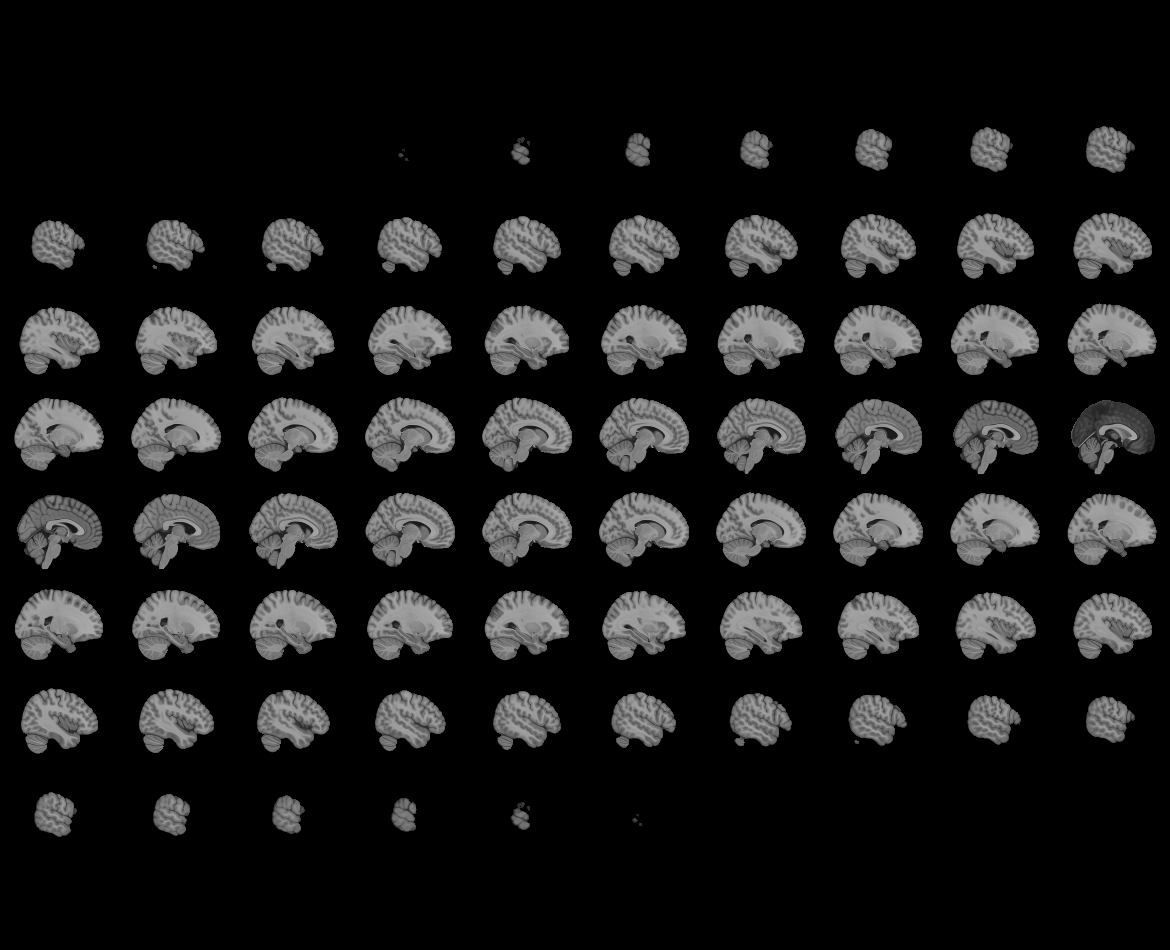
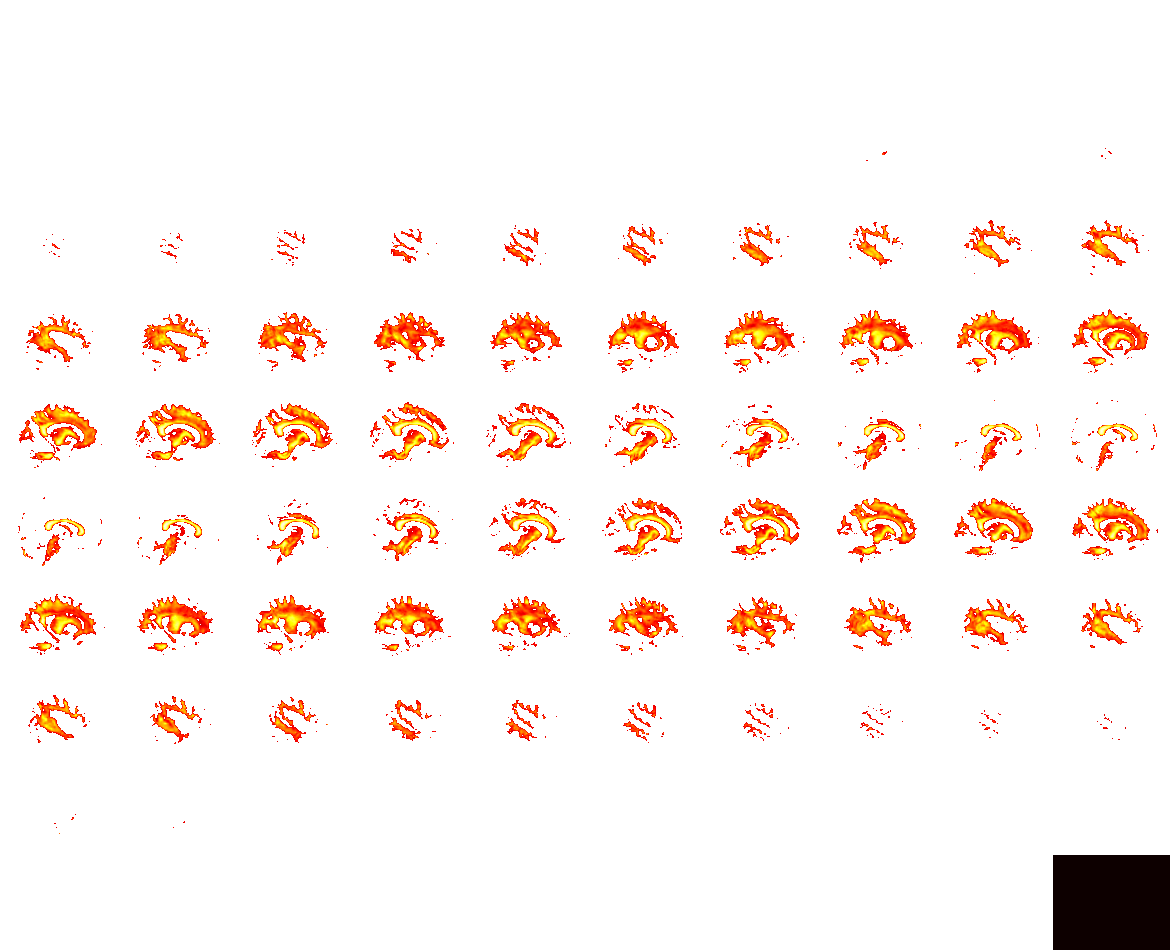

In [36]:
plotting.view_img('stats/mean_FA.nii.gz', threshold=0.3)

In [37]:
# Load FA map
fa_nii = nib.load("./FA/dti_FA_FA.nii.gz")
fa_data = fa_nii.get_fdata()

# Load V1 map
v1_nii = nib.load("../dti_V1.nii.gz")
v1_data = v1_nii.get_fdata()  # shape = (X, Y, Z, 3)

# Scale eigenvectors by FA to get color FA map (DEC map)
dec_data = np.abs(v1_data) * fa_data[..., None]

# Prepare header and save new image
hdr = v1_nii.header.copy()
hdr.set_intent("vector")
hdr["intent_name"] = b"RGB" 

dec_nii = nib.Nifti1Image(dec_data.astype(np.float32), v1_nii.affine, header=hdr)
nib.save(dec_nii, "./FA/dti_DEC.nii.gz")

In [38]:
nv = NiiVue() 
nv.load_volumes([{"path": './FA/dti_DEC.nii.gz'},
                ])
nv

NiiVue(clip_plane_depth_azi_elev=[2.0, 0.0, 0.0], draw_lut=None, graph=<ipyniivue.traits.Graph object at 0x7fe…

In [39]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/tbss_dti_DEC.png')

# Epilogue
This demonstration has showed you how to unwarp and preprocess a diffusion-weighted image for a single subject, which generates an FA image which you can use for statistical analysis. As an exercise, trying adapting this notebook to analyze a handful of subjects from the same dataset, calculate their FA images, and then submit them to a group-level analysis.

### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [40]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-11-06T02:44:30.058958+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

nibabel   : 5.3.2
IPython   : 8.16.1
nilearn   : 0.11.1
ipyniivue : 2.3.2
matplotlib: 3.8.4
numpy     : 2.2.4

